## 1. Import Libraries

In [1]:

# Data manipulation
import pandas as pd
import numpy as np
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# HuggingFace libraries
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

# Scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

# PyTorch
import torch

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)


## 2. Load Preprocessed Dataset

In [3]:
# Define paths
DATA_DIR = Path("./data")
MODELS_DIR = Path("./models")
BERT_MODELS_DIR = MODELS_DIR / "bert_models"
BERT_MODELS_DIR.mkdir(exist_ok=True, parents=True)

INPUT_FILE = DATA_DIR / "english_clean.csv"

print(f"📂 Data directory: {DATA_DIR.resolve()}")
print(f"📂 Models directory: {BERT_MODELS_DIR.resolve()}")
print(f"📄 Input file: {INPUT_FILE.name}")

📂 Data directory: C:\Users\Nguyen Ngo\Downloads\English\English\data
📂 Models directory: C:\Users\Nguyen Ngo\Downloads\English\English\models\bert_models
📄 Input file: english_clean.csv


In [4]:
# Load dataset
df = pd.read_csv(INPUT_FILE)

print(f"✅ Loaded dataset: {len(df):,} records")
print(f"\n📊 Dataset shape: {df.shape}")
print(f"\n🔍 Columns: {df.columns.tolist()}")

# Remove rows with missing critical data
df = df.dropna(subset=['clean_text', 'label'])
print(f"\n📊 Final dataset size: {len(df):,} records")

# Display label distribution
print("\n🏷️  Label distribution:")
print(df['label'].value_counts())

df.head()

✅ Loaded dataset: 1,334 records

📊 Dataset shape: (1334, 9)

🔍 Columns: ['title', 'url', 'root_category', 'subcategory', 'label', 'combined_text', 'clean_text', 'word_count', 'timestamp']

📊 Final dataset size: 1,334 records

🏷️  Label distribution:
label
drug       607
fraud      452
guide      134
other       96
hacking     45
Name: count, dtype: int64


,title,url,root_category,subcategory,label,combined_text,clean_text,word_count,timestamp
0,USA FULLZ + DL + BACKGROUND REPORT MONTANA | N...,http://nemesis555nchzn2dogee6mlc7xxgeeshqirmh3...,Fraud,SSN/DOB/DL/PII,fraud,USA FULLZ + DL + BACKGROUND REPORT MONTANA | N...,usa fullz dl background report montana nemesis...,23,2023-01-11T13:00:52
1,1 x POWER PLANT XL autoflower seed | Nemesis M...,http://nemesis555nchzn2dogee6mlc7xxgeeshqirmh3...,Drugs,Cannabis,drug,1 x POWER PLANT XL autoflower seed | Nemesis M...,1 x power plant xl autoflower seed nemesis mar...,189,2023-01-11T13:00:01
2,Ship Marijuana Safely - Instant Delivery | Nem...,http://nemesis555nchzn2dogee6mlc7xxgeeshqirmh3...,Other,Guides and Tutorials,guide,Ship Marijuana Safely - Instant Delivery | Nem...,ship marijuana safely instant delivery nemesis...,142,2023-01-11T12:59:34
3,1x Feminized AUTOFLOWER AK-47 Cannabis Seeds |...,http://nemesis555nchzn2dogee6mlc7xxgeeshqirmh3...,Drugs,Cannabis,drug,1x Feminized AUTOFLOWER AK-47 Cannabis Seeds |...,1x feminized autoflower ak 47 cannabis seeds n...,178,2023-01-11T12:59:08
4,1 x KALASHNIKOV autoflower seed | Nemesis Market,http://nemesis555nchzn2dogee6mlc7xxgeeshqirmh3...,Drugs,Cannabis,drug,1 x KALASHNIKOV autoflower seed | Nemesis Mark...,1 x kalashnikov autoflower seed nemesis market...,170,2023-01-11T12:58:53


## 3. Prepare Data for BERT

### 3.1 Encode Labels

In [5]:
# Encode labels to numeric values
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Create label mappings
label2id = {label: idx for idx, label in enumerate(label_encoder.classes_)}
id2label = {idx: label for label, idx in label2id.items()}

num_labels = len(label_encoder.classes_)

print(f"📊 Number of classes: {num_labels}")
print(f"\n🏷️  Label mappings:")
for label, idx in label2id.items():
    count = (df['label'] == label).sum()
    print(f"   {idx}: {label:15s} ({count:4d} samples)")

# Save label encoder
import pickle
with open(BERT_MODELS_DIR / 'label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print(f"\n💾 Saved label encoder to: label_encoder.pkl")

📊 Number of classes: 5

🏷️  Label mappings:
   0: drug            ( 607 samples)
   1: fraud           ( 452 samples)
   2: guide           ( 134 samples)
   3: hacking         (  45 samples)
   4: other           (  96 samples)

💾 Saved label encoder to: label_encoder.pkl


### 3.2 Train/Validation/Test Split

In [6]:
# Prepare features and labels
# Use 'combined_text' if available (title + description), otherwise 'clean_text'
text_column = 'combined_text' if 'combined_text' in df.columns else 'clean_text'
print(f"📝 Using text column: {text_column}")

X = df[text_column].values
y = df['label_encoded'].values

# First split: train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.30, 
    random_state=RANDOM_STATE, 
    stratify=y
)

# Second split: validation (15%) and test (15%) from temp (30%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.50, 
    random_state=RANDOM_STATE, 
    stratify=y_temp
)

print("✅ Data split complete!")
print(f"\n📊 Split sizes:")
print(f"   Train:      {len(X_train):4d} ({len(X_train)/len(X)*100:5.2f}%)")
print(f"   Validation: {len(X_val):4d} ({len(X_val)/len(X)*100:5.2f}%)")
print(f"   Test:       {len(X_test):4d} ({len(X_test)/len(X)*100:5.2f}%)")

📝 Using text column: combined_text
✅ Data split complete!

📊 Split sizes:
   Train:       933 (69.94%)
   Validation:  200 (14.99%)
   Test:        201 (15.07%)


### 3.3 Create HuggingFace Datasets

In [7]:
# Create dataset dictionaries
train_dict = {'text': X_train.tolist(), 'label': y_train.tolist()}
val_dict = {'text': X_val.tolist(), 'label': y_val.tolist()}
test_dict = {'text': X_test.tolist(), 'label': y_test.tolist()}

# Create HuggingFace datasets
train_dataset = Dataset.from_dict(train_dict)
val_dataset = Dataset.from_dict(val_dict)
test_dataset = Dataset.from_dict(test_dict)

# Create DatasetDict
dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

print("✅ HuggingFace datasets created!")
print(f"\n📊 Dataset structure:")
print(dataset_dict)

# Sample from train dataset
print(f"\n📋 Sample from training set:")
sample = train_dataset[0]
print(f"   Text: {sample['text'][:200]}...")
print(f"   Label: {sample['label']} ({id2label[sample['label']]})")

✅ HuggingFace datasets created!

📊 Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 933
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 201
    })
})

📋 Sample from training set:
   Text: Bank Transfers For Beginners | 100% Working! | Nemesis Market. This is a guide on how to do bank transfers and make huuggee money with it. Also for beginners. All my items are tested and working 100%....
   Label: 2 (guide)


## 4. Tokenization

We'll prepare tokenizers for all three models but start with BERT.

In [8]:
# Define model checkpoints
MODEL_CHECKPOINTS = {
    'BERT': 'bert-base-uncased',
    'RoBERTa': 'roberta-base',
    'XLM-RoBERTa': 'xlm-roberta-base'
}

# Start with BERT
current_model_name = 'RoBERTa'
model_checkpoint = MODEL_CHECKPOINTS[current_model_name]

print(f"🤖 Loading tokenizer for: {current_model_name}")
print(f"   Checkpoint: {model_checkpoint}")

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

print(f"\n✅ Tokenizer loaded successfully!")
print(f"   Vocab size: {tokenizer.vocab_size:,}")
print(f"   Max length: {tokenizer.model_max_length}")

🤖 Loading tokenizer for: RoBERTa
   Checkpoint: roberta-base

✅ Tokenizer loaded successfully!
   Vocab size: 50,265
   Max length: 512


In [9]:
# Test tokenization
sample_text = train_dataset[0]['text']
print(f"📝 Sample text: {sample_text[:200]}...\n")

tokens = tokenizer(sample_text, truncation=True, padding=True)
print(f"🔤 Tokenized output:")
print(f"   Input IDs length: {len(tokens['input_ids'])}")
print(f"   Tokens: {tokenizer.convert_ids_to_tokens(tokens['input_ids'][:20])}...")

📝 Sample text: Bank Transfers For Beginners | 100% Working! | Nemesis Market. This is a guide on how to do bank transfers and make huuggee money with it. Also for beginners. All my items are tested and working 100%....

🔤 Tokenized output:
   Input IDs length: 88
   Tokens: ['<s>', 'Bank', 'ĠTrans', 'f', 'ers', 'ĠFor', 'ĠBegin', 'ners', 'Ġ|', 'Ġ100', '%', 'ĠWorking', '!', 'Ġ|', 'ĠNemesis', 'ĠMarket', '.', 'ĠThis', 'Ġis', 'Ġa']...


Token indices sequence length is longer than the specified maximum sequence length for this model (629 > 512). Running this sequence through the model will result in indexing errors


📊 Text length statistics (token counts):
   Mean:   172.5 tokens
   Median: 167 tokens
   95th percentile: 324 tokens
   99th percentile: 443 tokens
   Max:    646 tokens

🎯 Using max_length: 324 tokens


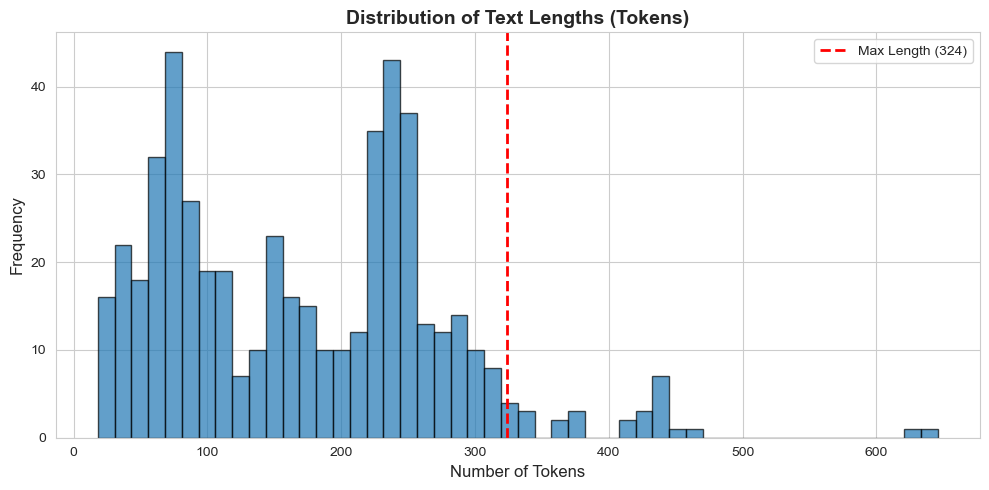

In [10]:
# Analyze text lengths to determine optimal max_length
text_lengths = [len(tokenizer.encode(text, truncation=False)) for text in X_train[:500]]  # Sample 500 for speed

print(f"📊 Text length statistics (token counts):")
print(f"   Mean:   {np.mean(text_lengths):.1f} tokens")
print(f"   Median: {np.median(text_lengths):.0f} tokens")
print(f"   95th percentile: {np.percentile(text_lengths, 95):.0f} tokens")
print(f"   99th percentile: {np.percentile(text_lengths, 99):.0f} tokens")
print(f"   Max:    {np.max(text_lengths)} tokens")

# Set max_length to cover 95% of texts
MAX_LENGTH = min(int(np.percentile(text_lengths, 95)), 512)  # BERT max is 512
print(f"\n🎯 Using max_length: {MAX_LENGTH} tokens")

# Visualize distribution
plt.figure(figsize=(10, 5))
plt.hist(text_lengths, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(MAX_LENGTH, color='red', linestyle='--', linewidth=2, label=f'Max Length ({MAX_LENGTH})')
plt.xlabel('Number of Tokens', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Text Lengths (Tokens)', fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=MAX_LENGTH
    )

# Tokenize all datasets
print("🔄 Tokenizing datasets...")
tokenized_datasets = dataset_dict.map(
    tokenize_function,
    batched=True,
    desc="Tokenizing"
)

print("\n✅ Tokenization complete!")
print(f"\n📊 Tokenized dataset structure:")
print(tokenized_datasets)

# Inspect tokenized sample
print(f"\n📋 Tokenized sample:")
print(f"   Keys: {tokenized_datasets['train'][0].keys()}")
print(f"   Input IDs shape: {len(tokenized_datasets['train'][0]['input_ids'])}")

🔄 Tokenizing datasets...


Tokenizing: 100%|██████████| 201/201 [00:00<00:00, 3650.62 examples/s]


✅ Tokenization complete!

📊 Tokenized dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 933
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 201
    })
})

📋 Tokenized sample:
   Keys: dict_keys(['text', 'label', 'input_ids', 'attention_mask'])
   Input IDs shape: 324


## 5. Fine-tune BERT

### 5.1 Load Pre-trained Model

In [12]:
# Load pre-trained model for sequence classification
print(f"🤖 Loading {current_model_name} model for sequence classification...")

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

# Move model to device
model.to(device)

print(f"\n✅ Model loaded successfully!")
print(f"   Parameters: {model.num_parameters():,}")
print(f"   Device: {next(model.parameters()).device}")

🤖 Loading RoBERTa model for sequence classification...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



✅ Model loaded successfully!
   Parameters: 124,649,477
   Device: cuda:0


### 5.2 Define Evaluation Metrics

In [13]:
# Define compute_metrics function for Trainer
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='macro', zero_division=0
    )
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

print("✅ Metrics function defined!")

✅ Metrics function defined!


### 5.3 Configure Training Arguments

In [14]:
# Define output directory
output_dir = BERT_MODELS_DIR / f"{current_model_name.lower()}_finetuned"

# Training arguments
training_args = TrainingArguments(
    output_dir=str(output_dir),
    
    # Training hyperparameters
    num_train_epochs=3,              # Number of epochs (3-5 is typical for BERT)
    per_device_train_batch_size=16,  # Batch size per GPU/CPU (adjust based on memory)
    per_device_eval_batch_size=32,   # Larger batch for evaluation
    learning_rate=2e-5,              # BERT typical learning rate (2e-5 to 5e-5)
    weight_decay=0.01,               # L2 regularization
    
    # Evaluation strategy
    evaluation_strategy="epoch",     # Evaluate at end of each epoch
    save_strategy="epoch",           # Save checkpoint at end of each epoch
    load_best_model_at_end=True,     # Load best model at end of training
    metric_for_best_model="f1",      # Use F1 score to determine best model
    
    # Logging
    logging_dir=str(output_dir / "logs"),
    logging_steps=50,
    
    # Early stopping
    save_total_limit=2,              # Keep only 2 best checkpoints
    
    # Reproducibility
    seed=RANDOM_STATE,
    
    # Performance
    fp16=torch.cuda.is_available(),  # Use mixed precision if GPU available
    
    # Disable Weights & Biases logging if not needed
    report_to="none"
)

print("🔧 Training arguments configured:")
print(f"   Epochs: {training_args.num_train_epochs}")
print(f"   Batch size (train): {training_args.per_device_train_batch_size}")
print(f"   Batch size (eval): {training_args.per_device_eval_batch_size}")
print(f"   Learning rate: {training_args.learning_rate}")
print(f"   Weight decay: {training_args.weight_decay}")
print(f"   FP16: {training_args.fp16}")
print(f"   Output dir: {output_dir.name}")

🔧 Training arguments configured:
   Epochs: 3
   Batch size (train): 16
   Batch size (eval): 32
   Learning rate: 2e-05
   Weight decay: 0.01
   FP16: True
   Output dir: roberta_finetuned


### 5.4 Initialize Trainer

In [15]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Stop if no improvement for 2 epochs
)

print("✅ Trainer initialized!")
print(f"   Total training steps: {len(tokenized_datasets['train']) // training_args.per_device_train_batch_size * training_args.num_train_epochs}")

✅ Trainer initialized!
   Total training steps: 174


### 5.5 Train the Model

In [16]:
# Train the model
print(f"\n🚀 Starting fine-tuning of {current_model_name}...\n")
print("=" * 80)

train_result = trainer.train()

print("\n" + "=" * 80)
print(f"✅ Training complete!\n")

# Print training metrics
print("📊 Training metrics:")
for key, value in train_result.metrics.items():
    print(f"   {key}: {value:.4f}" if isinstance(value, float) else f"   {key}: {value}")


🚀 Starting fine-tuning of RoBERTa...



 28%|██▊       | 50/177 [16:42<44:14, 20.90s/it] 

{'loss': 0.9841, 'grad_norm': 4.124752521514893, 'learning_rate': 1.4463276836158193e-05, 'epoch': 0.85}


                                                
 33%|███▎      | 59/177 [20:37<31:32, 16.04s/it]

{'eval_loss': 0.452688992023468, 'eval_accuracy': 0.82, 'eval_f1': 0.47155031792003727, 'eval_precision': 0.44324826374361975, 'eval_recall': 0.5205882352941177, 'eval_runtime': 66.3181, 'eval_samples_per_second': 3.016, 'eval_steps_per_second': 0.106, 'epoch': 1.0}


 56%|█████▋    | 100/177 [35:28<38:41, 30.15s/it] 

{'loss': 0.3702, 'grad_norm': 8.078592300415039, 'learning_rate': 8.926553672316384e-06, 'epoch': 1.69}


                                                 
 67%|██████▋   | 118/177 [44:22<18:13, 18.54s/it]

{'eval_loss': 0.46274593472480774, 'eval_accuracy': 0.86, 'eval_f1': 0.629410241174947, 'eval_precision': 0.626804428668019, 'eval_recall': 0.6532773109243697, 'eval_runtime': 65.4711, 'eval_samples_per_second': 3.055, 'eval_steps_per_second': 0.107, 'epoch': 2.0}


 85%|████████▍ | 150/177 [57:38<10:44, 23.88s/it]

{'loss': 0.3397, 'grad_norm': 4.078202247619629, 'learning_rate': 3.2768361581920903e-06, 'epoch': 2.54}


                                                   
100%|██████████| 177/177 [1:08:46<00:00, 16.69s/it]

{'eval_loss': 0.3123703896999359, 'eval_accuracy': 0.88, 'eval_f1': 0.693716061865708, 'eval_precision': 0.8368742711239205, 'eval_recall': 0.6808403361344537, 'eval_runtime': 62.6737, 'eval_samples_per_second': 3.191, 'eval_steps_per_second': 0.112, 'epoch': 3.0}


100%|██████████| 177/177 [1:09:30<00:00, 23.56s/it]


{'train_runtime': 4167.8197, 'train_samples_per_second': 0.672, 'train_steps_per_second': 0.042, 'train_loss': 0.5097445256292483, 'epoch': 3.0}

✅ Training complete!

📊 Training metrics:
   train_runtime: 4167.8197
   train_samples_per_second: 0.6720
   train_steps_per_second: 0.0420
   total_flos: 466045954228872.0000
   train_loss: 0.5097
   epoch: 3.0000


## 6. Model Evaluation

### 6.1 Validation Set Evaluation

In [17]:
# Evaluate on validation set
print("📊 Evaluating on validation set...\n")
val_results = trainer.evaluate(eval_dataset=tokenized_datasets['validation'])

print("=" * 80)
print(f"VALIDATION SET RESULTS - {current_model_name}")
print("=" * 80)
for key, value in val_results.items():
    if isinstance(value, float):
        print(f"   {key:20s}: {value:.4f}")
    else:
        print(f"   {key:20s}: {value}")
print("=" * 80)

📊 Evaluating on validation set...



100%|██████████| 7/7 [00:51<00:00,  7.38s/it]

VALIDATION SET RESULTS - RoBERTa
   eval_loss           : 0.3124
   eval_accuracy       : 0.8800
   eval_f1             : 0.6937
   eval_precision      : 0.8369
   eval_recall         : 0.6808
   eval_runtime        : 62.3280
   eval_samples_per_second: 3.2090
   eval_steps_per_second: 0.1120
   epoch               : 3.0000


### 6.2 Test Set Evaluation

In [18]:
# Evaluate on test set
print("\n📊 Evaluating on test set...\n")
test_results = trainer.evaluate(eval_dataset=tokenized_datasets['test'])

print("=" * 80)
print(f"TEST SET RESULTS - {current_model_name}")
print("=" * 80)
for key, value in test_results.items():
    if isinstance(value, float):
        print(f"   {key:20s}: {value:.4f}")
    else:
        print(f"   {key:20s}: {value}")
print("=" * 80)


📊 Evaluating on test set...



100%|██████████| 7/7 [00:51<00:00,  7.37s/it]

TEST SET RESULTS - RoBERTa
   eval_loss           : 0.3436
   eval_accuracy       : 0.8856
   eval_f1             : 0.6431
   eval_precision      : 0.6513
   eval_recall         : 0.6520
   eval_runtime        : 61.9313
   eval_samples_per_second: 3.2460
   eval_steps_per_second: 0.1130
   epoch               : 3.0000


### 6.3 Detailed Classification Report

In [19]:
# Get predictions on test set
predictions = trainer.predict(tokenized_datasets['test'])
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Classification report
print("\n" + "=" * 80)
print(f"DETAILED CLASSIFICATION REPORT - {current_model_name} (Test Set)")
print("=" * 80 + "\n")

target_names = [id2label[i] for i in range(num_labels)]
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

100%|██████████| 7/7 [00:56<00:00,  8.11s/it]


DETAILED CLASSIFICATION REPORT - RoBERTa (Test Set)

              precision    recall  f1-score   support

        drug     0.9891    1.0000    0.9945        91
       fraud     0.8750    0.9265    0.9000        68
       guide     0.5926    0.8000    0.6809        20
     hacking     0.0000    0.0000    0.0000         7
       other     0.8000    0.5333    0.6400        15

    accuracy                         0.8856       201
   macro avg     0.6513    0.6520    0.6431       201
weighted avg     0.8625    0.8856    0.8702       201



### 6.4 Confusion Matrix

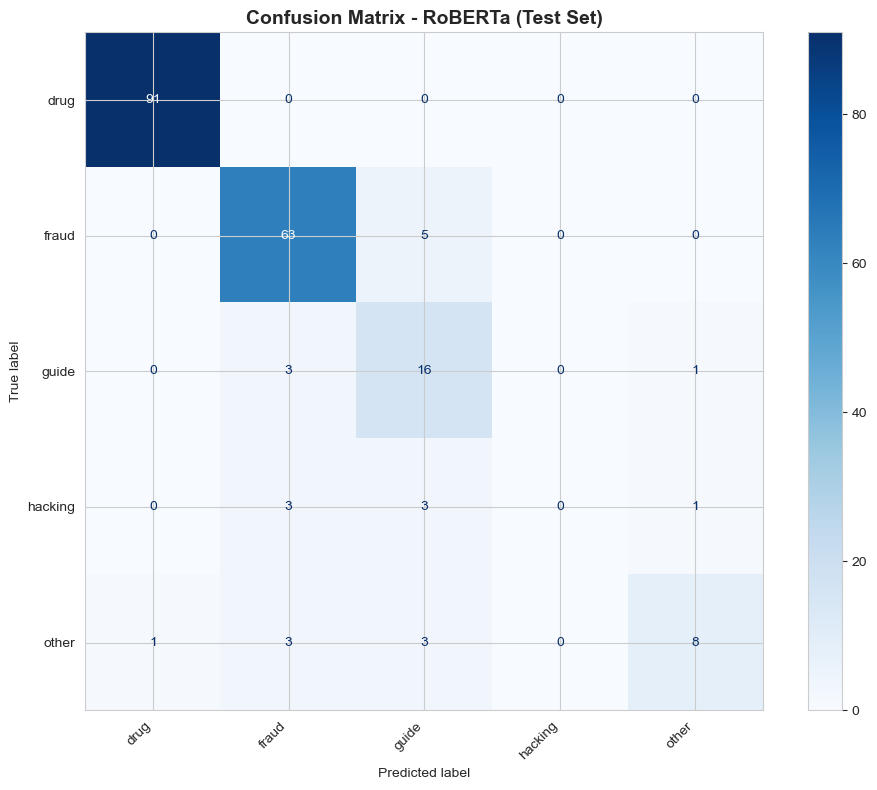


📊 Per-class accuracy:
   drug           : 1.0000 (91/91)
   fraud          : 0.9265 (63/68)
   guide          : 0.8000 (16/20)
   hacking        : 0.0000 (0/7)
   other          : 0.5333 (8/15)


In [20]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title(f'Confusion Matrix - {current_model_name} (Test Set)', 
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(BERT_MODELS_DIR / f'{current_model_name.lower()}_confusion_matrix.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# Per-class accuracy
print("\n📊 Per-class accuracy:")
for i, label in enumerate(target_names):
    class_acc = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
    print(f"   {label:15s}: {class_acc:.4f} ({cm[i, i]}/{cm[i].sum()})")

## 7. Compare with Baseline Models

In [21]:
# Load baseline results if available
baseline_results_path = MODELS_DIR / 'baseline_results.json'

if baseline_results_path.exists():
    with open(baseline_results_path, 'r') as f:
        baseline_data = json.load(f)
    
    # Get best baseline model results
    baseline_test_results = baseline_data['test_results']
    best_baseline = max(baseline_test_results, key=lambda x: x['F1-Score'])
    
    print("📊 Comparison with Baseline Models:\n")
    print("=" * 80)
    print(f"{'Model':<25} {'Accuracy':>12} {'Precision':>12} {'Recall':>12} {'F1-Score':>12}")
    print("=" * 80)
    
    # Best baseline
    print(f"{best_baseline['Model'] + ' (Baseline)':<25} "
          f"{best_baseline['Accuracy']:>12.4f} "
          f"{best_baseline['Precision']:>12.4f} "
          f"{best_baseline['Recall']:>12.4f} "
          f"{best_baseline['F1-Score']:>12.4f}")
    
    # BERT results
    bert_acc = test_results['eval_accuracy']
    bert_f1 = test_results['eval_f1']
    bert_prec = test_results['eval_precision']
    bert_rec = test_results['eval_recall']
    
    print(f"{current_model_name + ' (Fine-tuned)':<25} "
          f"{bert_acc:>12.4f} "
          f"{bert_prec:>12.4f} "
          f"{bert_rec:>12.4f} "
          f"{bert_f1:>12.4f}")
    
    print("=" * 80)
    
    # Calculate improvements
    f1_improvement = ((bert_f1 - best_baseline['F1-Score']) / best_baseline['F1-Score']) * 100
    acc_improvement = ((bert_acc - best_baseline['Accuracy']) / best_baseline['Accuracy']) * 100
    
    print(f"\n🎉 Improvements over best baseline:")
    print(f"   Accuracy:  {acc_improvement:+.2f}%")
    print(f"   F1-Score:  {f1_improvement:+.2f}%")
    
else:
    print("⚠️  Baseline results not found. Run baseline_models.ipynb first.")
    
    # Still show BERT results
    print(f"\n📊 {current_model_name} Test Results:")
    print(f"   Accuracy:  {test_results['eval_accuracy']:.4f}")
    print(f"   Precision: {test_results['eval_precision']:.4f}")
    print(f"   Recall:    {test_results['eval_recall']:.4f}")
    print(f"   F1-Score:  {test_results['eval_f1']:.4f}")

📊 Comparison with Baseline Models:

Model                         Accuracy    Precision       Recall     F1-Score
Linear SVM (Baseline)           0.8607       0.7484       0.6669       0.6969
RoBERTa (Fine-tuned)            0.8856       0.6513       0.6520       0.6431

🎉 Improvements over best baseline:
   Accuracy:  +2.89%
   F1-Score:  -7.72%


## 8. Save Fine-tuned Model

In [22]:
# Save the fine-tuned model and tokenizer
final_model_dir = BERT_MODELS_DIR / f"{current_model_name.lower()}_final"

print(f"💾 Saving fine-tuned model to: {final_model_dir.name}")

trainer.save_model(str(final_model_dir))
tokenizer.save_pretrained(str(final_model_dir))

print("✅ Model and tokenizer saved successfully!")

# Save evaluation results
results_dict = {
    'model_name': current_model_name,
    'model_checkpoint': model_checkpoint,
    'validation_results': val_results,
    'test_results': test_results,
    'training_args': {
        'num_epochs': training_args.num_train_epochs,
        'batch_size': training_args.per_device_train_batch_size,
        'learning_rate': training_args.learning_rate,
        'max_length': MAX_LENGTH
    },
    'label_mappings': {
        'label2id': label2id,
        'id2label': id2label
    }
}

results_file = BERT_MODELS_DIR / f'{current_model_name.lower()}_results.json'
with open(results_file, 'w') as f:
    json.dump(results_dict, f, indent=2)

print(f"💾 Saved evaluation results to: {results_file.name}")

💾 Saving fine-tuned model to: roberta_final
✅ Model and tokenizer saved successfully!
💾 Saved evaluation results to: roberta_results.json


## 9. Summary

In [23]:
# Final summary
print("\n" + "=" * 80)
print(f"{current_model_name} FINE-TUNING SUMMARY")
print("=" * 80)

print(f"\n📁 Dataset:")
print(f"   Total samples: {len(df):,}")
print(f"   Train/Val/Test: {len(X_train)}/{len(X_val)}/{len(X_test)}")
print(f"   Number of classes: {num_labels}")
print(f"   Classes: {', '.join(target_names)}")

print(f"\n🤖 Model:")
print(f"   Architecture: {current_model_name}")
print(f"   Checkpoint: {model_checkpoint}")
print(f"   Parameters: {model.num_parameters():,}")
print(f"   Max sequence length: {MAX_LENGTH} tokens")

print(f"\n🔧 Training:")
print(f"   Epochs: {training_args.num_train_epochs}")
print(f"   Batch size: {training_args.per_device_train_batch_size}")
print(f"   Learning rate: {training_args.learning_rate}")
print(f"   Device: {device}")

print(f"\n📊 Test Results:")
print(f"   Accuracy:  {test_results['eval_accuracy']:.4f}")
print(f"   Precision: {test_results['eval_precision']:.4f}")
print(f"   Recall:    {test_results['eval_recall']:.4f}")
print(f"   F1-Score:  {test_results['eval_f1']:.4f}")

print(f"\n💾 Saved Artifacts:")
print(f"   - Fine-tuned model: {final_model_dir.name}/")
print(f"   - Tokenizer: {final_model_dir.name}/")
print(f"   - Label encoder: label_encoder.pkl")
print(f"   - Results: {results_file.name}")
print(f"   - Confusion matrix: {current_model_name.lower()}_confusion_matrix.png")

print(f"\n🎯 Next Steps:")
print(f"   1. Fine-tune RoBERTa model (change current_model_name to 'RoBERTa')")
print(f"   2. Fine-tune XLM-RoBERTa model (change current_model_name to 'XLM-RoBERTa')")
print(f"   3. Compare all models and select the best one")
print(f"   4. Model interpretation and error analysis")
print(f"   5. Deploy the best model for inference")

print("\n" + "=" * 80)
print(f"✅ {current_model_name} FINE-TUNING COMPLETE!")
print("=" * 80)


RoBERTa FINE-TUNING SUMMARY

📁 Dataset:
   Total samples: 1,334
   Train/Val/Test: 933/200/201
   Number of classes: 5
   Classes: drug, fraud, guide, hacking, other

🤖 Model:
   Architecture: RoBERTa
   Checkpoint: roberta-base
   Parameters: 124,649,477
   Max sequence length: 324 tokens

🔧 Training:
   Epochs: 3
   Batch size: 16
   Learning rate: 2e-05
   Device: cuda

📊 Test Results:
   Accuracy:  0.8856
   Precision: 0.6513
   Recall:    0.6520
   F1-Score:  0.6431

💾 Saved Artifacts:
   - Fine-tuned model: roberta_final/
   - Tokenizer: roberta_final/
   - Label encoder: label_encoder.pkl
   - Results: roberta_results.json
   - Confusion matrix: roberta_confusion_matrix.png

🎯 Next Steps:
   1. Fine-tune RoBERTa model (change current_model_name to 'RoBERTa')
   2. Fine-tune XLM-RoBERTa model (change current_model_name to 'XLM-RoBERTa')
   3. Compare all models and select the best one
   4. Model interpretation and error analysis
   5. Deploy the best model for inference

✅ RoBE

## 10. Training History Visualization (Optional)

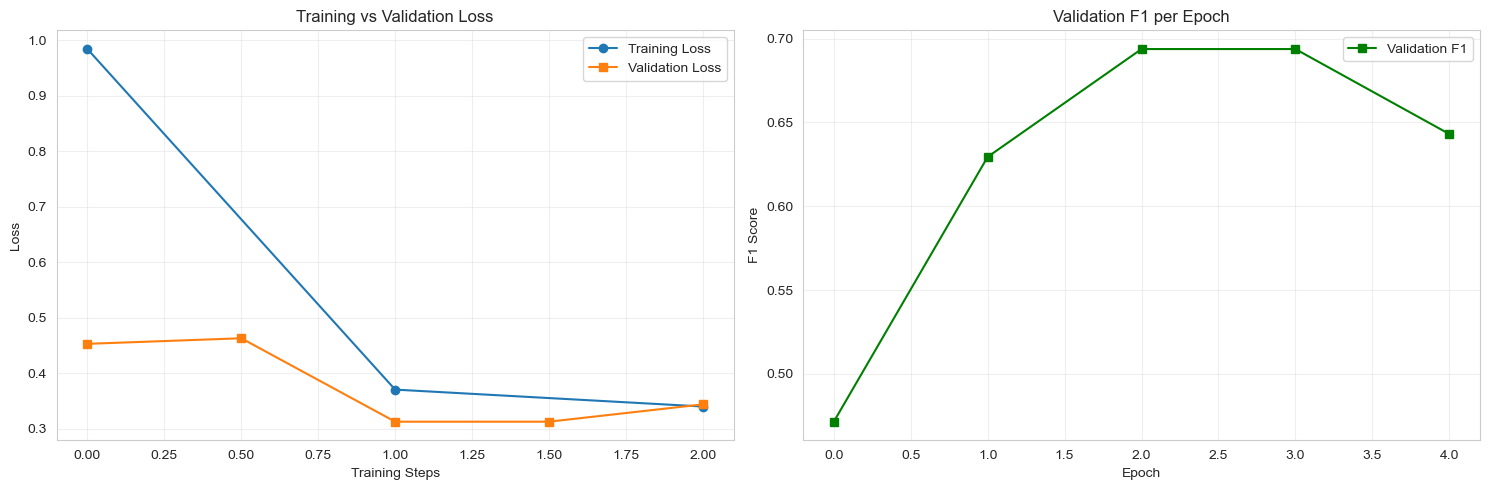

💾 Saved training history plot to models\bert_models\roberta_training_history.png


In [24]:
log_history = trainer.state.log_history

# Extract training & validation metrics
train_loss = [entry['loss'] for entry in log_history if 'loss' in entry]
eval_loss  = [entry['eval_loss'] for entry in log_history if 'eval_loss' in entry]
eval_f1    = [entry['eval_f1'] for entry in log_history if 'eval_f1' in entry]

if train_loss and eval_loss:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # -------------------------
    # 1) Training loss (per step)
    # -------------------------
    ax1.plot(train_loss, label='Training Loss', marker='o')

    # -------------------------
    # 2) Validation loss (per epoch)
    # -------------------------
    ax1.plot(
        np.linspace(0, len(train_loss)-1, num=len(eval_loss)),
        eval_loss,
        label='Validation Loss',
        marker='s'
    )

    ax1.set_xlabel('Training Steps')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training vs Validation Loss')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # -------------------------
    # 3) Validation F1 per epoch
    # -------------------------
    ax2.plot(eval_f1, label='Validation F1', marker='s', color='green')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('F1 Score')
    ax2.set_title('Validation F1 per Epoch')
    ax2.grid(alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    
    save_path = BERT_MODELS_DIR / f"{current_model_name.lower()}_training_history.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"💾 Saved training history plot to {save_path}")
else:
    print("⚠️ Training history not available.")


---

## To Fine-tune Other Models:

**RoBERTa:**
1. Change `current_model_name = 'RoBERTa'` in section 4
2. Re-run from section 4 onwards

**XLM-RoBERTa:**
1. Change `current_model_name = 'XLM-RoBERTa'` in section 4
2. Re-run from section 4 onwards

All models will be saved separately in the `models/bert_models/` directory.